# Imports, styles, etc

In [1]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy

import scipy.stats as stats

import sys
sys.path.append('../utils/')
from data import *
from liwc import *
from analisys import *

In [25]:
plt.rcParams['axes.labelsize']  = 14 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.5

In [23]:
plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

# Reading and processing data

In [4]:
def liwc_sentence_parse(s,liwc):
    return liwc.parse(s.split(' '))

def get_key_counts(counter,key):
    if key in counter:
        return counter[key]
    else:
        return 0

LIWC_FILEPATH = '../data/LIWC2015_English_Flat.dic'
liwc = Liwc(LIWC_FILEPATH)

df = get_movies_dataset()
df['liwc_count'] = df['text_clean'].apply(liwc_sentence_parse, args=(liwc,))
df['bad_words_count'] = df['tags_count'].apply(get_key_counts,args=(' __ ',))
df = df[df.bad_words_count==0]
df = df.drop(columns = ['tags_count','bad_words_count'])

In [5]:
scores = pd.DataFrame()
for file in os.listdir('../data/03_scored/without_inputation/normal_toxicity/'):
    tmp = pd.read_csv('../data/03_scored/without_inputation/normal_toxicity/'+file)
    tmp['id']=file
    scores = scores.append(tmp, ignore_index=True)
scores['len'] = scores.text.str.split(' ').str.len()

total_score = (scores.groupby('id')['score'].sum()/scores.groupby('id')['len'].sum()).sort_values()[::-1]

In [6]:
df = df.set_index('id')
df['score'] = total_score
df = df.reset_index()
df = df[df.score.notna()]

In [7]:
d = get_movies_dataset()
d['bad_words_count'] = d['tags_count'].apply(get_key_counts,args=(' __ ',))

In [8]:
#subtitles without any imputation
print(d[d.bad_words_count==0].shape)
d[d.bad_words_count==0].groupby('group').count()

(553, 10)


,movie,age,has-en-sub,url,id,text,text_clean,tags_count,bad_words_count
group,,,,,,,,,
Black Man,82,82,82,82,82,82,82,82,82
Black Woman,42,42,42,42,42,42,42,42,42
White Man,267,267,267,267,267,267,267,267,267
White Woman,162,162,162,162,162,162,162,162,162


---

# Processing data with LIWC

In [9]:
#LIWC data

liwc_df = pd.DataFrame().from_records(df['liwc_count'],index=df['id'])
liwc_df = liwc_df.fillna(0)

#normalizing 
liwc_df_norm = (liwc_df[liwc.categories.values()].T * ( 1 / liwc_df[liwc.categories.values()].sum(axis=1) )).T

liwc_df_norm.reset_index(inplace=True)
liwc_df_norm['group'] = df['group']
liwc_df_norm['age'] = df['age']

In [10]:
#calculating mean rank for each liwc category in order to apply kruskall-wallis test

liwc_df_rank = liwc_df_norm.copy()
for col in liwc.categories.values():
    liwc_df_rank[col] = liwc_df_rank[col].rank()

---

## Kruscal-Wallis Test

In [11]:
experiments = []
old_experiments = []

for feature in liwc.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='White Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='White Woman'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Man'][feature],
        liwc_df_norm[liwc_df_norm.group=='Black Woman'][feature],
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

---

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [12]:
import statsmodels.stats.multitest as smt
idx = smt.multipletests(pvals=experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(experiments[idx].sort_values('pvalue')))
experiments[idx].sort_values('pvalue')

15


,feature,statistic,pvalue
20,quant,45.429640,7.498099e-10
67,informal,38.059231,2.746028e-08
59,space,37.242565,4.088498e-08
15,verb,37.131304,4.316250e-08
69,netspeak,32.476639,4.152565e-07
57,relativ,32.394058,4.322421e-07
9,article,32.313947,4.493822e-07
13,conj,31.979148,5.286691e-07
19,number,31.956363,5.345469e-07
70,assent,31.594096,6.372621e-07


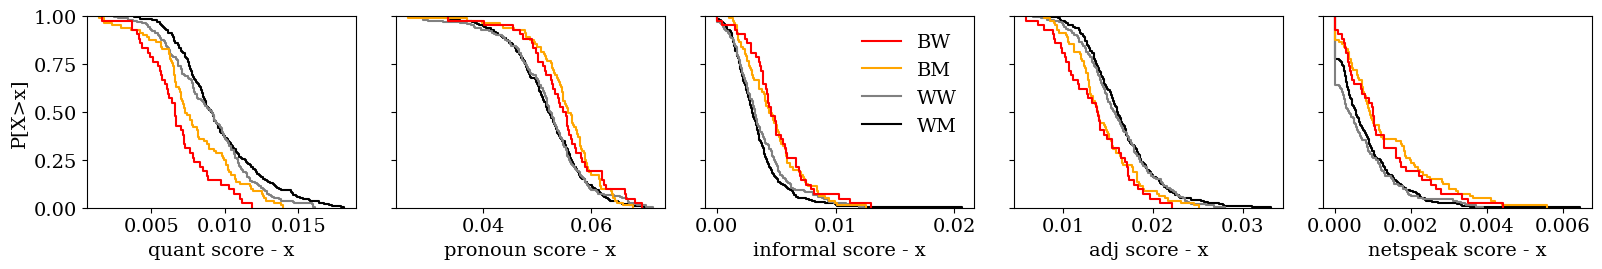

In [35]:
ploting_vars = ['quant','pronoun','informal','adj','netspeak']

fig, axes = plt.subplots(1, 5,sharey=True,sharex=False,figsize=(16,2.8))
axes = axes.ravel()

for i,var in enumerate(ploting_vars): 
    if i==2:
        g = sns.ecdfplot(
            liwc_df_norm, 
            x=var, 
            hue="group",
            complementary=True, 
            ax=axes[i],
            legend=True,
            hue_order=['Black Woman','Black Man','White Woman', 'White Man'],
            palette=['red','orange','grey','black']
        ) 
        g.legend_.set_title(None)
        new_labels = ['BW', 'BM','WW','WM']
        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        g.legend_.set_frame_on(False)
        g.legend_.set_frame_on(False)
    else:
        sns.ecdfplot(
            liwc_df_norm, 
            x=var, 
            hue="group",
            complementary=True, 
            ax=axes[i],
            legend=False, 
            hue_order=['Black Woman','Black Man','White Woman', 'White Man'],
            palette=['red','orange','grey','black']
        )
    axes[i].set(ylabel='P[X>x]',xlabel='%s score - x'%var)

fig.tight_layout()
plt.savefig('liwc_dists.pdf')
plt.show()


In [29]:
g.legend_.set_zorder()

TypeError: get_legend_handler() missing 2 required positional arguments: 'legend_handler_map' and 'orig_handle'

# individual categories analisys

### calculating liwc per sentence

In [14]:
scores_liwc = scores.copy().set_index('id')
scores_liwc = scores_liwc.merge(df[['id','group']], on='id')

#text treatment
text = scores_liwc.text
text = text.str.lower()
text = text.str.replace('\n','')
text = text.str.replace("[^a-zA-Z\\s]+",'')
while text.str.contains('  ').any():
    text = text.str.replace("  ",' ')
scores_liwc['text'] = text

#computing columns
scores_liwc['len'] = text.str.split(' ').str.len()
scores_liwc['liwc_counter'] = scores_liwc.text.str.split(' ').apply(liwc.parse) #computing liwc
scores_liwc = scores_liwc.reset_index().rename(columns={'index':'sentence_id'})
scores_liwc.head()

,sentence_id,id,text,score,len,group,liwc_counter
0,0,BL-RLlaB8fw,hey oh hey whats up bradley just want to take ...,0.183550,15,White Man,"{'social': 3, 'informal': 3, 'nonflu': 1, 'fun..."
1,1,BL-RLlaB8fw,right wow i really need to shave hey guys cars...,0.071084,15,White Man,"{'relativ': 2, 'space': 1, 'affect': 1, 'posem..."
2,2,BL-RLlaB8fw,to any movie in the last few months youve prob...,0.033210,15,White Man,"{'function': 8, 'prep': 3, 'quant': 2, 'cogpro..."
3,3,BL-RLlaB8fw,little movie called a star is born this film w...,0.092404,15,White Man,"{'relativ': 2, 'space': 1, 'leisure': 2, 'verb..."
4,4,BL-RLlaB8fw,buzz and it stars lady gaga and bradley cooper...,0.280691,15,White Man,"{'function': 7, 'conj': 3, 'pronoun': 4, 'ipro..."


In [15]:
# sentences_liwc_counts = pd.DataFrame(columns=list(liwc.categories.values())+['sentence_id'])

# for data in tqdm(scores_liwc.itertuples()):
#     d = dict(data.liwc_counter)
#     d['sentence_id'] = data.sentence_id
#     sentences_liwc_counts = sentences_liwc_counts.append(d,ignore_index=True)

# sentences_liwc_counts['sentence_id'] = sentences_liwc_counts['sentence_id'].astype(int)
# sentences_liwc_counts = sentences_liwc_counts.fillna(0)

In [16]:
# sentences_liwc_counts.to_csv('../data/sentences_liwc_counts.csv',index=False)
sentences_liwc_counts = pd.read_csv('../data/sentences_liwc_counts.csv')

In [17]:
#normaliza
sentences_liwc_counts_scored = sentences_liwc_counts.copy().set_index('sentence_id')
sentences_liwc_counts_scored = sentences_liwc_counts_scored.replace({0:np.nan})
sentences_liwc_counts_scored = (sentences_liwc_counts_scored[liwc.categories.values()].T * ( 1 / sentences_liwc_counts_scored[liwc.categories.values()].sum(axis=1) )).T

# #mergeia para pegar group e score
sentences_liwc_counts_scored = sentences_liwc_counts_scored.reset_index()
sentences_liwc_counts_scored = sentences_liwc_counts_scored.merge(scores_liwc[['sentence_id','score','group']],on='sentence_id').set_index('sentence_id')

sentences_liwc_counts_scored = sentences_liwc_counts_scored.fillna(0)

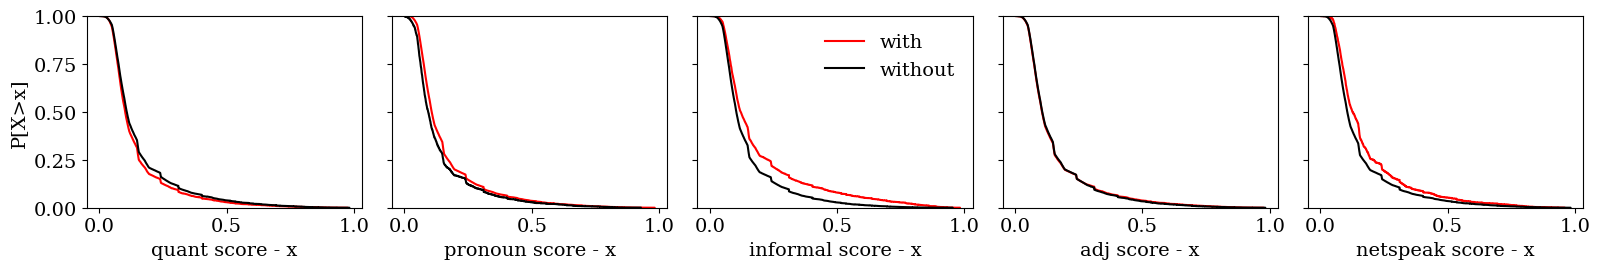

In [43]:
ploting_vars = ['quant','pronoun','informal','adj','netspeak']

fig, axes = plt.subplots(1, 5,sharey=True,sharex=False,figsize=(16,2.8))
axes = axes.ravel()

for i,var in enumerate(ploting_vars):
    if i==2:
        g2 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]>0].score, complementary=True,ax=axes[i],legend=True, color='red')
        g1 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]==0].score, complementary=True,ax=axes[i],legend=True,color='black')
        
#         break
        g2.legend(['with','without'])
        g1.legend_.set_title(None)
        
        new_labels = ['with','without']
        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        g2.legend_.set_frame_on(False)
        g2.legend_.set_frame_on(False)
        
    else:
        sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]>0].score, complementary=True,ax=axes[i],legend=False,color='red')
        g1 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored[var]==0].score, complementary=True,ax=axes[i],legend=False,color='black')
        

    axes[i].set(ylabel='P[X>x]',xlabel='%s score - x'%var)

fig.tight_layout()
plt.savefig('liwc_toxicity_dists.pdf')
plt.show()



### KS test and bonferroni correction

In [19]:
liwc_toxicity_experiments = []

for feature in ploting_vars:
    
    result = stats.ks_2samp(
        sentences_liwc_counts_scored[sentences_liwc_counts_scored[feature]==0].score,
        sentences_liwc_counts_scored[sentences_liwc_counts_scored[feature]>0].score
    )
    liwc_toxicity_experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
liwc_toxicity_experiments = pd.DataFrame(liwc_toxicity_experiments)
liwc_toxicity_experiments

,feature,statistic,pvalue
0,quant,0.045881,5.254759e-22
1,pronoun,0.126690,3.692351e-39
2,informal,0.099188,2.321264e-61
3,adj,0.010466,9.924000e-02
4,netspeak,0.110875,4.392570e-22


In [20]:
idx_tox = smt.multipletests(pvals=liwc_toxicity_experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(liwc_toxicity_experiments[idx_tox].sort_values('pvalue')))
liwc_toxicity_experiments[idx_tox].sort_values('pvalue')

4


,feature,statistic,pvalue
2,informal,0.099188,2.321264e-61
1,pronoun,0.126690,3.692351e-39
4,netspeak,0.110875,4.392570e-22
0,quant,0.045881,5.254759e-22


---

# Avg. words per video

In [107]:
scores_liwc.groupby(['id','group']).sum()[['len']].reset_index().groupby('group').mean()

,len
group,
Black Man,1620.621951
Black Woman,2004.857143
White Man,1369.548872
White Woman,1475.814815


In [54]:
df[(df.movie=='Black Panther')].groupby('group').count()

,id,movie,age,has-en-sub,url,text,text_clean,liwc_count,score
group,,,,,,,,,
Black Man,2,2,2,2,2,2,2,2,2
Black Woman,2,2,2,2,2,2,2,2,2
White Man,2,2,2,2,2,2,2,2,2
White Woman,1,1,1,1,1,1,1,1,1


In [43]:
scores_liwc.groupby('id').sum()

,sentence_id,score,len
id,,,
-3jWCt_ETXA,487435,11.026277,973
-66g38EP0pI,1146775,12.767810,1047
-7YPgSlV50o,2256144,66.849328,5273
-MPdGhvdPpE,1714284,11.810967,1318
-Tb1yXcloI4,959646,24.558148,2110
...,...,...,...
zPowwt-XyPM,592875,9.633697,1121
zftWshmtEyU,3724574,24.510206,2573
ziJskU2D-EY,13346424,58.322787,5246


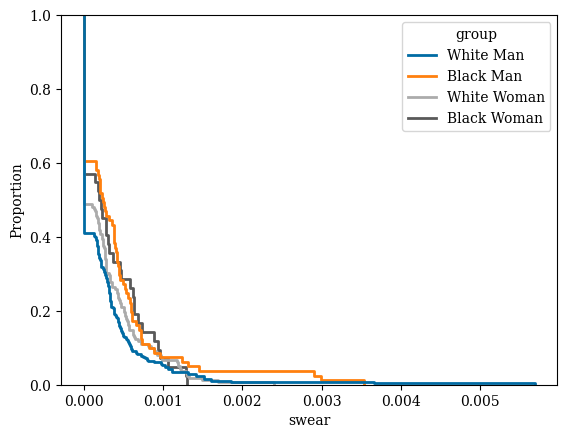

In [49]:
sns.ecdfplot(liwc_df_norm, x='swear', hue="group",complementary=True,legend=True) 
plt.show()

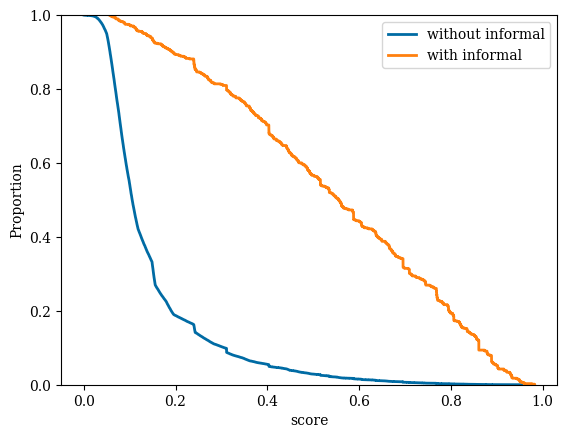

In [45]:
g1 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored.swear==0].score,complementary=True)
g2 = sns.ecdfplot(sentences_liwc_counts_scored[sentences_liwc_counts_scored.swear>0].score,complementary=True)
plt.legend(['without informal','with informal'])
plt.show()

In [253]:
g.legend([''])

0.19118570982150387

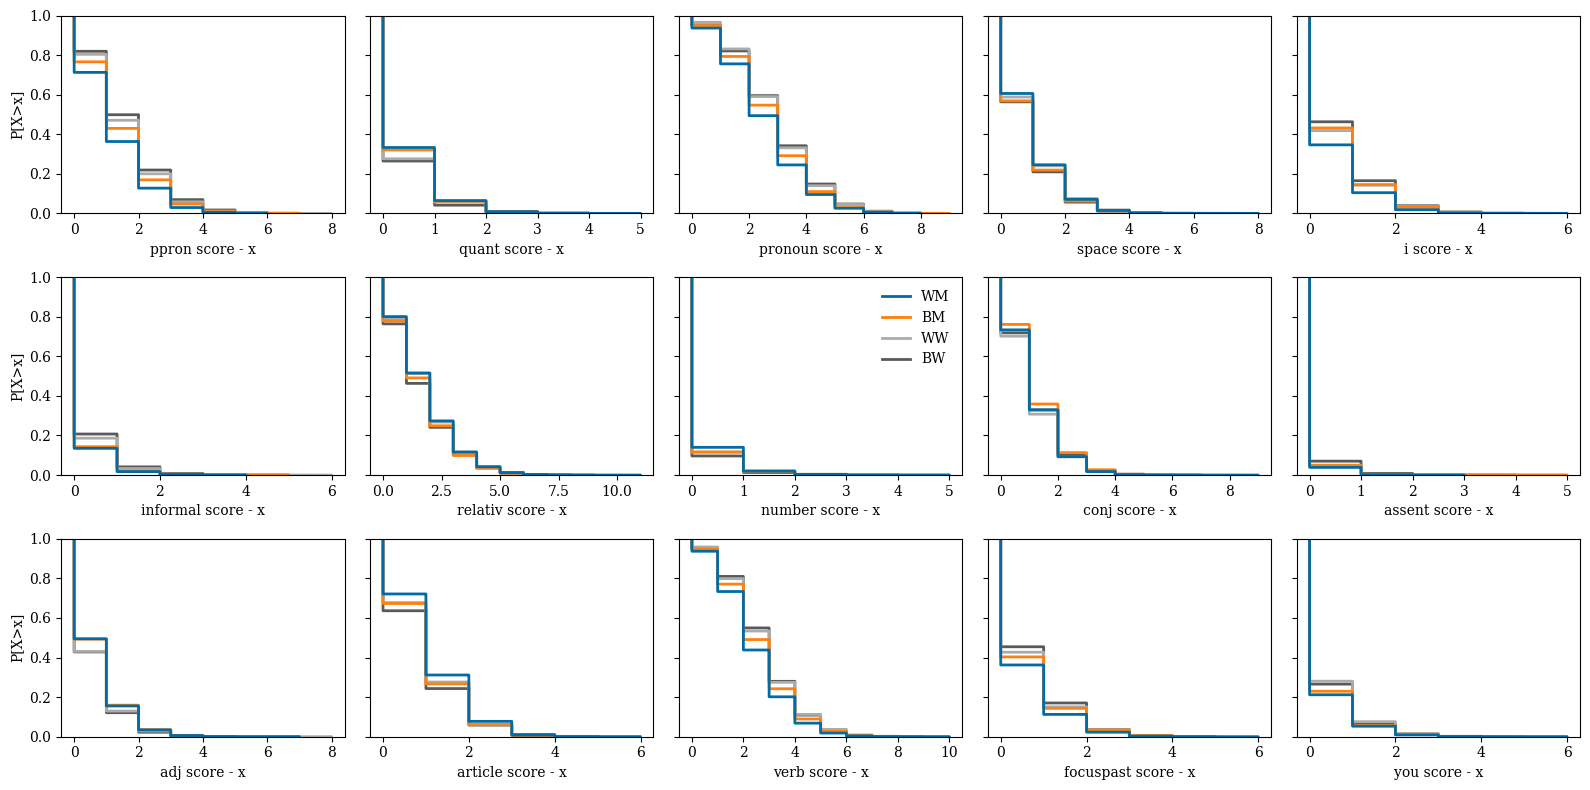

In [231]:
fig, axes = plt.subplots(3, 5,sharey=True,sharex=False,figsize=(16,8))
axes = axes.ravel()

for i,var in enumerate(interesting_var[:15]): 
#     aux = liwx_df
    if i==7:
        g = sns.ecdfplot(sentences_liwc_counts_scored, x=var, hue="group",complementary=True, ax=axes[i],legend=True) 
        g.legend_.set_title(None)
        new_labels = ['WM', 'BM','WW','BW']
        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        g.legend_.set_frame_on(False)
        g.legend_.set_frame_on(False)
    else:
        sns.ecdfplot(sentences_liwc_counts_scored, x=var, hue="group",complementary=True, ax=axes[i],legend=False)#,hue_norm=(500,500,500,500)) 
    axes[i].set(ylabel='P[X>x]',xlabel='%s score - x'%var)


fig.tight_layout()
# plt.savefig('liwc_dists.pdf')
plt.show()


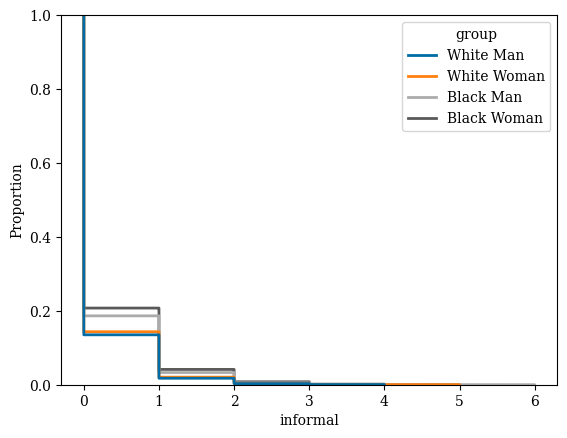

In [232]:
sns.ecdfplot(sentences_liwc_counts_scored[,x='informal',hue='group',complementary=True)
plt.show()

In [217]:
informal_sentences_scored

,sentence_id,id,text,score,len,group,liwc_counter
0,0,BL-RLlaB8fw,hey oh hey whats up bradley just want to take ...,0.183550,15,White Man,"{'social': 3, 'informal': 3, 'nonflu': 1, 'fun..."
1,1,BL-RLlaB8fw,right wow i really need to shave hey guys cars...,0.071084,15,White Man,"{'relativ': 2, 'space': 1, 'affect': 1, 'posem..."
14,14,BL-RLlaB8fw,very dense subject matter and i feel like it t...,0.162613,15,White Man,"{'function': 8, 'adverb': 2, 'adj': 1, 'relati..."
46,46,BL-RLlaB8fw,like oh this is not the ending and then it rep...,0.085977,15,White Man,"{'function': 12, 'prep': 3, 'compare': 1, 'inf..."
53,53,BL-RLlaB8fw,yeah theyre right she killed it especially for...,0.525257,15,White Man,"{'informal': 1, 'assent': 1, 'function': 10, '..."
...,...,...,...,...,...,...,...
54792,54792,jZ03fZwADWg,no wonder everyone hates white people do you s...,0.860626,15,White Woman,"{'function': 8, 'negate': 1, 'verb': 6, 'cogpr..."
54808,54808,jZ03fZwADWg,didnt know what it was thats a fun sound okay ...,0.071152,15,White Woman,"{'function': 9, 'auxverb': 4, 'negate': 1, 've..."
54809,54809,jZ03fZwADWg,wrap up this video before all these weird soun...,0.243387,15,White Woman,"{'function': 6, 'prep': 2, 'drives': 1, 'power..."
54812,54812,jZ03fZwADWg,great movie and im sure its gonna win a whole ...,0.094434,15,White Woman,"{'adj': 1, 'affect': 4, 'posemo': 4, 'drives':..."


In [216]:
informal_sentences_scored = sentences_liwc_counts_scored[sentences_liwc_counts_scored.liwc_counter.apply(lambda x: 'informal' in x)]
sns.displot(informal_sentences_scored, x='swear',hue='group',kind='ecdf',complementary=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'liwc_counter'

In [ ]:
groups_counts_df = pd.DataFrame(columns=['categories','count','group','word']).set_index(['group','word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (group,word) not in groups_counts_df.index:
                groups_counts_df.loc[(group,word),:] = (str(list(liwc.parse([word]).keys())),1)
            else:
                groups_counts_df.loc[(group,word),'count'] += 1
groups_counts_df = groups_counts_df.reset_index()


## Black people use more informalities

<Figure size 640x480 with 0 Axes>

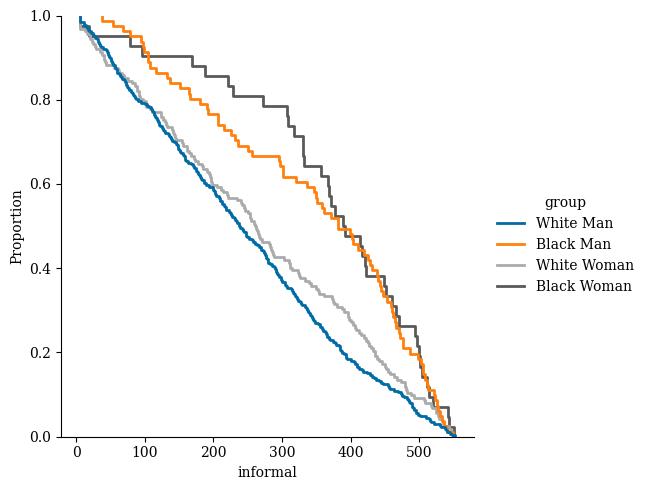

In [269]:
sns.displot(liwc_df_rank, x="informal", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()
plt.savefig('informal.pdf')

In [16]:
sns.displot(liwc_df_rank, x="netspeak", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('netspeak.pdf')

In [17]:
sns.displot(liwc_df_rank, x="assent", hue="group", kind="ecdf",complementary=True, legend=False) #
plt.savefig('assent.pdf')

In [18]:
sns.displot(liwc_df_rank, x="filler", hue="group", kind="ecdf",complementary=True, legend=False) #
plt.savefig('filler.pdf')

In [19]:
display(liwc_df_norm[['informal','group']].groupby('group').mean(),liwc_df_rank[['informal','group']].groupby('group').mean())

,informal
group,
Black Man,0.004713
Black Woman,0.005030
White Man,0.003368
White Woman,0.003668


,informal
group,
Black Man,344.160494
Black Woman,368.559524
White Man,247.206767
White Woman,267.200617


# cogproc

In [20]:
display(liwc_df_norm[['cogproc','group']].groupby('group').mean(),liwc_df_rank[['cogproc','group']].groupby('group').mean())

,cogproc
group,
Black Man,0.041737
Black Woman,0.042310
White Man,0.043198
White Woman,0.044043


,cogproc
group,
Black Man,244.283951
Black Woman,254.011905
White Man,274.783835
White Woman,300.518519


## Others stats 

### swear - fuck, damn, shit

In [21]:
sns.displot(liwc_df_rank, x="swear", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('swear.pdf')

In [22]:
display(liwc_df_norm[['swear','group']].groupby('group').mean(),liwc_df_rank[['swear','group']].groupby('group').mean())

,swear
group,
Black Man,0.000406
Black Woman,0.000327
White Man,0.000233
White Woman,0.000270


,swear
group,
Black Man,319.975309
Black Woman,310.595238
White Man,256.112782
White Woman,280.203704


### prep - prepositions - to, with, above 

In [23]:
sns.displot(liwc_df_rank, x="prep", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.savefig('prep.pdf')

### anx - worried, fearful

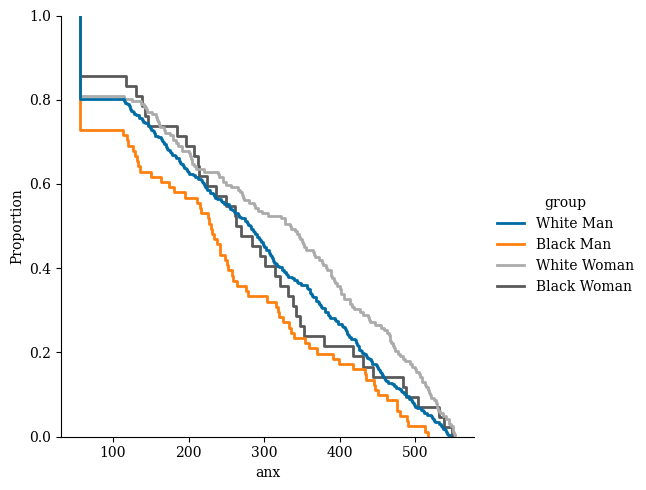

In [133]:
sns.displot(liwc_df_rank, x="anx", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()

### percept - Perceptual processes - look, heard, feeling 

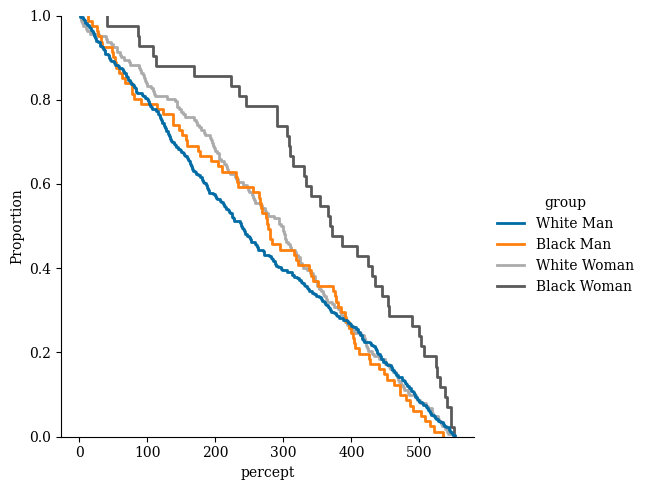

In [134]:
sns.displot(liwc_df_rank, x="percept", hue="group", kind="ecdf",complementary=True) #dicionario de palavroes do liwc
plt.show()

### conj - Conjunctions - and, but, whereas

In [26]:
sns.displot(liwc_df_rank, x="conj", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('conj.pdf')

### function - Total function words - it, to, no, very

In [27]:
sns.displot(liwc_df_rank, x="function", hue="group", kind="ecdf",complementary=True, legend=False) #dicionario de palavroes do liwc
plt.savefig('function.pdf')

---
# investigating each category most used words by group

In [152]:
str(list(liwc.parse([word]).keys()))

"['social', 'relativ', 'time']"

In [157]:
categories = ['informal','cogproc', 'swear','anx','percept'] # liwc.categories.values()

groups_counts = {} # pd.DataFrame(columns=['group','category','word','count'])
groups_counts_df = pd.DataFrame(columns=['categories','count','group','word']).set_index(['group','word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (group,word) not in groups_counts_df.index:
                groups_counts_df.loc[(group,word),:] = (str(list(liwc.parse([word]).keys())),1)
            else:
                groups_counts_df.loc[(group,word),'count'] += 1
groups_counts_df = groups_counts_df.reset_index()


100%|██████████| 42/42 [18:15<00:00, 26.08s/it] 


In [195]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})

In [162]:
# groups_counts_df.to_csv('../data/categories_groups_counts_df.csv',index=False)

In [166]:
groups_counts_df

,group,word,categories,count
0,White Man,I,[],6615
1,White Man,saw,"['verb', 'percept', 'see', 'focuspast']",149
2,White Man,black,"['percept', 'see']",120
3,White Man,panther,[],19
4,White Man,and,"['function', 'conj']",12915
...,...,...,...,...
45640,Black Woman,jimmy,[],2
45641,Black Woman,cagne,[],1
45642,Black Woman,jim,[],1
45643,Black Woman,cagney,[],2


### informal

In [199]:
bw_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('informal'))
]
bw_informal['freq'] = bw_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
bw_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-199-fa7bdd924ab0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bw_informal['freq'] = bw_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,oh,"['informal', 'nonflu']",251,0.00296389,NaN,NaN
1,Black Woman,gonna,"['verb', 'focusfuture', 'relativ', 'motion', '...",173,0.00204284,NaN,NaN
2,Black Woman,okay,"['affect', 'posemo', 'informal', 'assent']",155,0.00183029,NaN,NaN
3,Black Woman,well,"['function', 'adverb', 'affect', 'posemo', 'in...",143,0.00168859,NaN,NaN
4,Black Woman,um,"['informal', 'nonflu']",119,0.00140519,NaN,NaN
5,Black Woman,yeah,"['informal', 'assent']",105,0.00123987,NaN,NaN
6,Black Woman,yes,"['informal', 'assent']",45,0.000531375,NaN,NaN
7,Black Woman,cool,"['adj', 'affect', 'posemo', 'percept', 'feel',...",29,0.000342441,NaN,NaN
8,Black Woman,hey,"['social', 'informal']",29,0.000342441,NaN,NaN
9,Black Woman,absolutely,"['function', 'adverb', 'cogproc', 'certain', '...",27,0.000318825,NaN,NaN


In [200]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Man') & (groups_counts_df.categories.str.contains('informal'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-200-57f1bdac38f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Man,well,"['function', 'adverb', 'affect', 'posemo', 'in...",864,0.00235558,NaN,NaN
1,White Man,gonna,"['verb', 'focusfuture', 'relativ', 'motion', '...",565,0.0015404,NaN,NaN
2,White Man,yeah,"['informal', 'assent']",301,0.000820638,NaN,NaN
3,White Man,uh,"['informal', 'nonflu']",202,0.000550727,NaN,NaN
4,White Man,um,"['informal', 'nonflu']",199,0.000542548,NaN,NaN
5,White Man,oh,"['informal', 'nonflu']",195,0.000531642,NaN,NaN
6,White Man,absolutely,"['function', 'adverb', 'cogproc', 'certain', '...",174,0.000474388,NaN,NaN
7,White Man,okay,"['affect', 'posemo', 'informal', 'assent']",141,0.000384418,NaN,NaN
8,White Man,cool,"['adj', 'affect', 'posemo', 'percept', 'feel',...",110,0.000299901,NaN,NaN
9,White Man,yes,"['informal', 'assent']",108,0.000294448,NaN,NaN


### swear

In [201]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('swear'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-201-2d8500db1ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",16,0.000188933,NaN,NaN
1,Black Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",12,0.0001417,damn,0.779738
2,Black Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",8,9.44666e-05,hell,0.483667
3,Black Woman,sucks,"['verb', 'affect', 'negemo', 'anger', 'focuspr...",5,5.90416e-05,NaN,NaN
4,Black Woman,badass,"['informal', 'swear']",5,5.90416e-05,NaN,NaN
5,Black Woman,dumb,"['adj', 'affect', 'negemo', 'anger', 'informal...",5,5.90416e-05,dumb,0.845482
6,Black Woman,dang,"['informal', 'swear']",4,4.72333e-05,NaN,NaN
7,Black Woman,freakin,"['affect', 'negemo', 'informal', 'swear']",4,4.72333e-05,NaN,NaN
8,Black Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",4,4.72333e-05,NaN,NaN
9,Black Woman,ass,"['bio', 'body', 'informal', 'swear']",2,2.36167e-05,ass,0.932329


In [203]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Woman') & (groups_counts_df.categories.str.contains('swear'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-203-b17cb5e83f6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Woman,badass,"['informal', 'swear']",19,7.90412e-05,NaN,NaN
1,White Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",13,5.40808e-05,damn,0.779738
2,White Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",12,4.99208e-05,hell,0.483667
3,White Woman,ass,"['bio', 'body', 'informal', 'swear']",12,4.99208e-05,ass,0.932329
4,White Woman,heck,"['informal', 'swear']",12,4.99208e-05,NaN,NaN
5,White Woman,butt,"['bio', 'body', 'informal', 'swear']",9,3.74406e-05,butt,0.769914
6,White Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",9,3.74406e-05,NaN,NaN
7,White Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",9,3.74406e-05,NaN,NaN
8,White Woman,shitty,"['affect', 'negemo', 'anger', 'bio', 'body', '...",9,3.74406e-05,shitty,0.949928
9,White Woman,hella,"['informal', 'swear', 'netspeak']",9,3.74406e-05,NaN,NaN


### cogproc

In [212]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('cogproc'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-212-e4a29866a6bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,know,"['verb', 'cogproc', 'insight', 'focuspresent']",646,0.00762818,NaN,NaN
1,Black Woman,but,"['function', 'conj', 'cogproc', 'differ']",643,0.00759275,NaN,NaN
2,Black Woman,really,"['function', 'adverb', 'cogproc', 'differ']",489,0.00577427,NaN,NaN
3,Black Woman,not,"['function', 'negate', 'cogproc', 'differ']",456,0.0053846,NaN,NaN
4,Black Woman,because,"['function', 'conj', 'cogproc', 'cause']",393,0.00464067,NaN,NaN
5,Black Woman,all,"['quant', 'cogproc', 'certain']",337,0.00397941,NaN,NaN
6,Black Woman,if,"['function', 'conj', 'cogproc', 'discrep', 'te...",309,0.00364877,NaN,NaN
7,Black Woman,think,"['verb', 'cogproc', 'insight', 'focuspresent']",268,0.00316463,NaN,NaN
8,Black Woman,how,"['function', 'adverb', 'conj', 'interrog', 'co...",251,0.00296389,NaN,NaN
9,Black Woman,or,"['function', 'conj', 'cogproc', 'tentat', 'dif...",230,0.00271592,NaN,NaN


In [213]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Man') & (groups_counts_df.categories.str.contains('cogproc'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-213-8cb6bfc60f3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Man,but,"['function', 'conj', 'cogproc', 'differ']",2934,0.00799917,NaN,NaN
1,White Man,really,"['function', 'adverb', 'cogproc', 'differ']",2529,0.00689499,NaN,NaN
2,White Man,know,"['verb', 'cogproc', 'insight', 'focuspresent']",1989,0.00542275,NaN,NaN
3,White Man,not,"['function', 'negate', 'cogproc', 'differ']",1653,0.00450669,NaN,NaN
4,White Man,all,"['quant', 'cogproc', 'certain']",1573,0.00428858,NaN,NaN
5,White Man,because,"['function', 'conj', 'cogproc', 'cause']",1327,0.00361789,NaN,NaN
6,White Man,think,"['verb', 'cogproc', 'insight', 'focuspresent']",1316,0.0035879,NaN,NaN
7,White Man,if,"['function', 'conj', 'cogproc', 'discrep', 'te...",1231,0.00335616,NaN,NaN
8,White Man,or,"['function', 'conj', 'cogproc', 'tentat', 'dif...",1064,0.00290086,NaN,NaN
9,White Man,some,"['quant', 'cogproc', 'tentat']",1029,0.00280544,NaN,NaN


### anx

In [215]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & (groups_counts_df.categories.str.contains('anx'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-215-64f77ba7253e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score
0,Black Woman,scary,"['adj', 'affect', 'negemo', 'anx']",32,0.000377866,NaN,NaN
1,Black Woman,horror,"['affect', 'negemo', 'anx']",29,0.000342441,NaN,NaN
2,Black Woman,fear,"['affect', 'negemo', 'anx']",14,0.000165317,fear,0.142798
3,Black Woman,scared,"['adj', 'affect', 'negemo', 'anx']",11,0.000129892,NaN,NaN
4,Black Woman,shy,"['adj', 'affect', 'negemo', 'anx', 'social']",9,0.000106275,NaN,NaN
5,Black Woman,uncomfortable,"['affect', 'negemo', 'anx']",6,7.085e-05,NaN,NaN
6,Black Woman,terrifying,"['adj', 'affect', 'negemo', 'anx']",6,7.085e-05,NaN,NaN
7,Black Woman,horrible,"['adj', 'affect', 'negemo', 'anx']",5,5.90416e-05,NaN,NaN
8,Black Woman,shook,"['verb', 'affect', 'negemo', 'anx', 'focuspast...",5,5.90416e-05,NaN,NaN
9,Black Woman,afraid,"['adj', 'affect', 'negemo', 'anx']",5,5.90416e-05,NaN,NaN


In [216]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Woman') & (groups_counts_df.categories.str.contains('anx'))
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(20).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-216-c228f5d16615>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score
0,White Woman,horror,"['affect', 'negemo', 'anx']",134,0.000365334,NaN,NaN
1,White Woman,tension,"['affect', 'negemo', 'anx']",59,0.000160856,NaN,NaN
2,White Woman,worry,"['verb', 'affect', 'negemo', 'anx', 'focuspres...",28,7.63384e-05,NaN,NaN
3,White Woman,scary,"['adj', 'affect', 'negemo', 'anx']",26,7.08856e-05,NaN,NaN
4,White Woman,fear,"['affect', 'negemo', 'anx']",22,5.99802e-05,fear,0.142798
5,White Woman,awkward,"['affect', 'negemo', 'anx', 'social']",21,5.72538e-05,NaN,NaN
6,White Woman,worried,"['adj', 'affect', 'negemo', 'anx']",18,4.90747e-05,NaN,NaN
7,White Woman,uncomfortable,"['affect', 'negemo', 'anx']",17,4.63483e-05,NaN,NaN
8,White Woman,terrifying,"['adj', 'affect', 'negemo', 'anx']",17,4.63483e-05,NaN,NaN
9,White Woman,struggling,"['affect', 'negemo', 'anx', 'drives', 'power']",16,4.36219e-05,NaN,NaN


### quant

In [290]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='Black Woman') & groups_counts_df.categories.str.contains('informal') & groups_counts_df.categories.str.contains('swear')
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(30).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-290-9e461a842f48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='Black Woman')]['count'].sum()


,group,word,categories,count,freq,words,score,stem
0,Black Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",16,0.000188933,NaN,NaN,NaN
1,Black Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",12,0.0001417,damn,0.779738,damn
2,Black Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",8,9.44666e-05,hell,0.483667,hell
3,Black Woman,sucks,"['verb', 'affect', 'negemo', 'anger', 'focuspr...",5,5.90416e-05,NaN,NaN,NaN
4,Black Woman,badass,"['informal', 'swear']",5,5.90416e-05,NaN,NaN,NaN
5,Black Woman,dumb,"['adj', 'affect', 'negemo', 'anger', 'informal...",5,5.90416e-05,dumb,0.845482,dumb
6,Black Woman,dang,"['informal', 'swear']",4,4.72333e-05,NaN,NaN,NaN
7,Black Woman,freakin,"['affect', 'negemo', 'informal', 'swear']",4,4.72333e-05,NaN,NaN,NaN
8,Black Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",4,4.72333e-05,NaN,NaN,NaN
9,Black Woman,ass,"['bio', 'body', 'informal', 'swear']",2,2.36167e-05,ass,0.932329,ass


In [292]:
wm_informal = groups_counts_df[
    (groups_counts_df.group=='White Woman') & (groups_counts_df.categories.str.contains('informal')) & groups_counts_df.categories.str.contains('swear')
]
wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()
wm_informal.sort_values('count',ascending=False).head(30).merge(word_scores, left_on='word', right_on='words',how='left')

<ipython-input-292-2801b55c5b3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wm_informal['freq'] = wm_informal['count']/groups_counts_df[(groups_counts_df.group=='White Man')]['count'].sum()


,group,word,categories,count,freq,words,score,stem
0,White Woman,badass,"['informal', 'swear']",19,5.1801e-05,NaN,NaN,NaN
1,White Woman,damn,"['affect', 'negemo', 'anger', 'informal', 'swe...",13,3.54428e-05,damn,0.779738,damn
2,White Woman,hell,"['affect', 'negemo', 'anger', 'relig', 'inform...",12,3.27164e-05,hell,0.483667,hell
3,White Woman,ass,"['bio', 'body', 'informal', 'swear']",12,3.27164e-05,ass,0.932329,ass
4,White Woman,heck,"['informal', 'swear']",12,3.27164e-05,NaN,NaN,NaN
5,White Woman,butt,"['bio', 'body', 'informal', 'swear']",9,2.45373e-05,butt,0.769914,butt
6,White Woman,freaking,"['affect', 'negemo', 'informal', 'swear']",9,2.45373e-05,NaN,NaN,NaN
7,White Woman,sucked,"['verb', 'affect', 'negemo', 'anger', 'focuspa...",9,2.45373e-05,NaN,NaN,NaN
8,White Woman,shitty,"['affect', 'negemo', 'anger', 'bio', 'body', '...",9,2.45373e-05,shitty,0.949928,shitti
9,White Woman,hella,"['informal', 'swear', 'netspeak']",9,2.45373e-05,NaN,NaN,NaN


---

# Diferences between groups on toxicity score

### Kruskal-wallis test

In [12]:
result = stats.kruskal(
        df[df.group=='White Man']['score'],
        df[df.group=='White Woman']['score'],
        df[df.group=='Black Man']['score'],
        df[df.group=='Black Woman']['score'],
    )
result

KeyError: 'score'

In [ ]:
sns.displot(df, x="score", hue="group", kind="ecdf",complementary=True) #checar o que sao adjetivos

---

# Bad Words

In [192]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})
bad_words = word_scores[word_scores.score>0.2]

In [ ]:
word_scores[word_scores.words=='w']

In [235]:
import nltk
sno = nltk.stem.SnowballStemmer('english')
word_scores['stem'] = word_scores['words'].apply(lambda x: sno.stem(x)) 
word_scores

In [239]:

bad_words_counts_df_steam = pd.DataFrame(columns=['count','group','bad_word']).set_index(['group','bad_word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (sno.stem(word) ==word_scores.stem).any():
                if (group,word) not in bad_words_counts_df_steam.index:
                    bad_words_counts_df_steam.loc[(group,word),'count'] = 1
                else:
                    bad_words_counts_df_steam.loc[(group,word),'count'] += 1
bad_words_counts_df_steam = bad_words_counts_df_steam.reset_index()

100%|██████████| 42/42 [00:19<00:00,  2.16it/s]


In [241]:
bad_words_counts_df_steam.reset_index()

,index,group,bad_word,count
0,0,White Man,black,120
1,1,White Man,dead,47
2,2,White Man,kill,22
3,3,White Man,Black,45
4,4,White Man,killed,17
...,...,...,...,...
1288,1288,Black Woman,lied,2
1289,1289,Black Woman,Asians,1
1290,1290,Black Woman,disease,1
1291,1291,Black Woman,blows,1


In [228]:

bad_words_counts_df = pd.DataFrame(columns=['count','group','bad_word']).set_index(['group','bad_word'])

for group in df.group.unique():
    for sent in tqdm(df[df.group==group]['text_clean'].str.split(' ')):
        for word in sent:
            if (word ==word_scores.words).any():
                if (group,word) not in bad_words_counts_df.index:
                    bad_words_counts_df.loc[(group,word),'count'] = 1
                else:
                    bad_words_counts_df.loc[(group,word),'count'] += 1
bad_words_counts_df = bad_words_counts_df.reset_index()

100%|██████████| 42/42 [00:19<00:00,  2.18it/s]


In [254]:
for group in df.group.unique():
    bad_words_counts_df.loc[bad_words_counts_df.group==group,'freq'] = (
        bad_words_counts_df[bad_words_counts_df.group==group]['count']
        /
        groups_counts_df[groups_counts_df.group==group]['count'].sum()
    )

In [263]:
bad_words_counts_df = bad_words_counts_df.merge(word_scores, left_on='bad_word',right_on='words')[['group','bad_word','count','freq','score']]

In [321]:
bad_words_counts_df.to_csv('../data/bad_words_counts_df.csv', index=False)

In [266]:
bad_words_counts_df[bad_words_counts_df.score>0.2].sort_values('freq',ascending=False).groupby('group').head(10).sort_values(['group','freq'],ascending=False)

,group,bad_word,count,freq,score
2,White Woman,black,92,0.000382726,0.348820
6,White Woman,dead,41,0.000170563,0.441481
121,White Woman,death,41,0.000170563,0.636407
78,White Woman,die,28,0.000116482,0.709312
139,White Woman,murder,26,0.000108162,0.605843
181,White Woman,violence,21,8.73613e-05,0.353454
228,White Woman,fire,19,7.90412e-05,0.301820
106,White Woman,died,16,6.6561e-05,0.363736
14,White Woman,killed,16,6.6561e-05,0.664008
67,White Woman,stupid,15,6.24009e-05,0.914704


In [330]:
bad_words_counts_df[bad_words_counts_df.bad_word=='black']

,group,bad_word,count,freq,score,normalized_score


In [323]:
bad_words_counts_df[bad_words_counts_df.bad_word=='kill']

,group,bad_word,count,freq,score,normalized_score
8,White Man,kill,22,5.99802e-05,0.806061,0.000048
9,Black Man,kill,43,0.000320965,0.806061,0.000259
10,White Woman,kill,15,6.24009e-05,0.806061,0.000050
11,Black Woman,kill,16,0.000188933,0.806061,0.000152


In [329]:
bad_words_counts_df[bad_words_counts_df.bad_word=='dead']

,group,bad_word,count,freq,score,normalized_score
4,White Man,dead,47,0.000128139,0.441481,0.000057
5,Black Man,dead,27,0.000201536,0.441481,0.000089
6,White Woman,dead,41,0.000170563,0.441481,0.000075
7,Black Woman,dead,17,0.000200742,0.441481,0.000089


In [307]:
bad_words_counts_df['normalized_score'] = bad_words_counts_df['freq'] * bad_words_counts_df['score']
bad_words_counts_df['normalized_score'] = bad_words_counts_df['normalized_score'].astype(float)

In [309]:
bad_words_counts_df.groupby('group',as_index=False).sum()

,group,score,normalized_score
0,Black Man,49.243228,0.002319
1,Black Woman,44.644553,0.002536
2,White Man,67.904789,0.001650
3,White Woman,58.857698,0.001687


In [185]:
def get_word_count(text, word):
    text_s = pd.Series(text.split(' '))
    return (text_s==word).sum()

def get_bad_words_count(text, bad_words):
    total=0
    for bad_word in bad_words:
        total +=get_word_count(text,bad_word)
    return total

In [186]:
df['bad_words_count'] = df['text_clean'].apply(get_bad_words_count,args=(bad_words.words,)) 

KeyboardInterrupt: 

In [16]:
display(sns.lmplot(col="group", hue="group", data=df,x='bad_words_count',y='score'))
display(sns.lmplot(data=df,x='bad_words_count',y='score'))

KeyError: "['score'] not in index"

## Person correlation

In [ ]:
print('For all data:', scipy.stats.pearsonr(df.bad_words_count,df.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.pearsonr(df[df.group==group].bad_words_count, df[df.group==group].score))

## Spearman correlation

In [ ]:
print('For all data:', scipy.stats.spearmanr(df.bad_words_count,df.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.spearmanr(df[df.group==group].bad_words_count, df[df.group==group].score))

### Kruskal-Wallis on bad words count

In [ ]:
result = stats.kruskal(
        df[df.group=='White Man']['bad_words_count'],
        df[df.group=='White Woman']['bad_words_count'],
        df[df.group=='Black Man']['bad_words_count'],
        df[df.group=='Black Woman']['bad_words_count'],
    )
result

In [ ]:
sns.displot(df, x="bad_words_count", hue="group", kind="ecdf",complementary=True) #checar o que sao adjetivos

---

# Words relation - bad words

In [ ]:
bad_words = word_scores[word_scores.score>0.2]

bad_words = bad_words.set_index('words')
bad_words['White Man'] = np.nan
bad_words['Black Man'] = np.nan
bad_words['White Woman'] = np.nan
bad_words['Black Woman'] = np.nan

for bad_word in tqdm(bad_words.index):
    for group in df.group.unique():
        total = 0
        for sent in df[df.group==group].text_clean:
             total += get_word_count(sent,bad_word)
        bad_words.loc[bad_word,group] = total
            
# bad_words = bad_words.reset_index()

In [ ]:
display(bad_words['White Man'].sort_values(ascending=False).head(20))
display(bad_words['White Woman'].sort_values(ascending=False).head(20))
display(bad_words['Black Man'].sort_values(ascending=False).head(20))
display(bad_words['Black Woman'].sort_values(ascending=False).head(20))

### Word: dope - Black Man

In [ ]:
before,after = get_word_relations('dope', df[df['group']=="Black Man"].text_clean)

In [ ]:
display(before,after)

### Word: damn - Black Woman

In [ ]:
a,b = get_word_relations('damn', df[df['group']=="Black Woman"].text_clean)

In [ ]:
display(a,b)

### Word: gay - Black Woman

In [ ]:
a,b = get_word_relations('gay', df[df['group']=="Black Woman"].text_clean)

In [ ]:
display(a,b)

### Word: extra

In [ ]:
a,b = get_word_relations('hella', df.text_clean)

In [ ]:
display(a,b)

---

# Words relation - informal - LIWC

In [ ]:
informal = pd.DataFrame()
informal['White Man'] = np.nan
informal['Black Man'] = np.nan
informal['White Woman'] = np.nan
informal['Black Woman'] = np.nan

In [ ]:
for i,data in df.iterrows():
    for word in data.text_clean.split(' '):
        liwc_val = liwc.parse([word])['informal']
        if liwc_val>0:
            if word not in informal.index:
                informal.loc[word,data.group] = liwc_val
            else:
                informal.loc[word,data.group] += liwc_val
informal = informal.fillna(0)

In [ ]:
informal.idxmax()

In [ ]:
#We need to computete each informal word toxicity value to compare who much toxicity is added by this words

---

# Looking for correlations in the data

### Top k = 20

In [ ]:
topk = df.sort_values('score',ascending = False).groupby('group').head(20)

In [ ]:
_vars = ['swear','social','informal','netspeak','anx','adj','quant','filler']

for var in _vars:
    topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))

In [ ]:
sns.pairplot(topk[_vars+['score','group']], hue='group')

### Person correlation

In [ ]:
print('For all data:', scipy.stats.spearmanr(topk.bad_words_count,topk.score))

for group in df.group.unique():
    print('For {}:'.format(group), scipy.stats.spearmanr(topk[topk.group==group].bad_words_count, topk[topk.group==group].score))

In [ ]:
bad_words = word_scores[word_scores.score>0.2]

bad_words = bad_words.set_index('words')
bad_words['White Man'] = np.nan
bad_words['Black Man'] = np.nan
bad_words['White Woman'] = np.nan
bad_words['Black Woman'] = np.nan

for bad_word in tqdm(bad_words.index):
    for group in df.group.unique():
        total = 0
        for sent in df[df.group==group].text_clean:
             total += get_word_count(sent,bad_word)
        bad_words.loc[bad_word,group] = total
            

In [ ]:
data = json.load(open('../data/bad_words_scored.json'))
word_scores = pd.DataFrame({'words':data.keys(),'score': data.values()})
# bad_words = word_scores[word_scores.score>0.2]

In [ ]:
word_scores = []

In [ ]:
l = []
df['has_bad_word'] = False
for word in tqdm(word_scores[word_scores.score>0.8].words):
    df['has_bad_word'] |= df.text_clean.str.contains(word)
    print(word, df.text_clean.str.contains(word).sum())
    

In [ ]:
df.groupby('group').sum()

In [ ]:
df.groupby('group').count()

### Word: gay - Black Woman

In [ ]:
a,b = get_word_relations('gay', df[df['group']=="Black Woman"].text_clean)

In [ ]:
display(a,b)

In [ ]:
display(get_word_relations('ass',topk[topk.group=='Black Woman'].text_clean))
print()
display(get_word_relations('ass',topk[topk.group=='White Man'].text_clean))

In [ ]:
display(get_word_relations('black',topk[topk.group=='Black Woman'].text_clean))
print()
display(get_word_relations('black',topk[topk.group=='White Man'].text_clean))

---

In [ ]:
var = 'informal'
topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

---

In [ ]:
var = 'swear'
topk[var] = topk.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

df[var] = df.liwc_count.apply(get_key_counts,args=(var,))
display(sns.lmplot(col="group", hue="group", data=df,x=var,y='score'))

---

In [ ]:
experiments[experiments['pvalue']<0.02].sort_values('pvalue')